# Uma introdução a Ciência de Dados a partir das Fake News

TODO: Colocar logo da Big Data

As *Fake News* referem-se a desinformação, desinformação ou má informação, que são disseminadas pelo boca a boca ou pela mídia tradicional e, mais recentemente, por formas digitais de comunicação, como vídeos editados, memes, anúncios não verificados e rumores propagados pelas mídias sociais. tornou-se um problema sério, com o potencial de resultar em violência da multidão, suicídios etc. como resultado de informações erradas circuladas nas mídias sociais.

![fake news](imagens/fake_news.jpeg)

Nesse notebook iremos explorar métodos para reconhecer *Fake News* através de métodos baseados em *Machine Learning*, precisamente em métodos do campo de **Processamento de Linguagem Natural**.

## Funcionalidades básicas do Jupyter Notebook
Cada célula do Jupyter roda um conjunto de linhas de código em python.
Existem dois modos de rodar uma célula:
* **CTRL + Shift + Enter** para rodar a célula selecionada e ir para a próxima.
* **CTRL + Alt + Enter** para rodar a célula selecionada e criar uma em seguida.

Se estiver usando o Google Colab, você pode rodar uma célula utilizando o botão *play* ao lado.


Rode a célula a seguir:

In [28]:
print("Hello World!")

Hello World!


Agora rode a célula abaixo, sem criar uma nova, para importar as bibliotecas utilizadas durante o workshop:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
import re,string,unicodedata
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/vitor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Exploração de dados
Nessa parte iremos importar os dados e analisa-los, utilizando a biblioteca *pandas* exportada anteriormente:
```python
import pandas as pd
```
Iremos utilizar um banco de dados criado por pesquisadores do NILC(Núcleo Interinstitucional de Linguística Computacional), chamado [*Fake.Br Corpus*](https://github.com/roneysco/Fake.br-Corpus).

Para obtermos os dados, rode as células abaixo:

In [3]:
# Importando o dataset de notícias verdadeiras
dataset_true_url="https://raw.githubusercontent.com/vitorhi/Workshop_bigdata/master/true.csv"
true=pd.read_csv(dataset_true_url)

In [4]:
# Importando o dataset de notícias falsas
dataset_fake_url="https://raw.githubusercontent.com/vitorhi/Workshop_bigdata/master/fake.csv"
fake=pd.read_csv(dataset_fake_url)

Com isso, temos dois *datasets* armazenados em *dataframes* do pandas. 

Um chamado `true` e outro `fake` 

Verifique o começo do dataframe:

In [6]:
true.head()

,text
0,﻿O Podemos decidiu expulsar o deputado federa...
1,"Bolsonaro é um liberal completo, diz president..."
2,Ministro do STF libera Andrea Neves de prisão ...
3,"Apesar da abundância, cresce preocupação com p..."
4,"Por que Harvard e MIT levarão Dilma, Moro e Su..."


Faça o mesmo para o *dataframe* de notícias falsas

In [10]:
fake.head()

,text
0,Kátia Abreu diz que vai colocar sua expulsão e...
1,"Dr. Ray peita Bolsonaro, chama-o de conservad..."
2,Reinaldo Azevedo desmascarado pela Polícia Fed...
3,Relatório assustador do BNDES mostra dinheiro ...
4,"Radialista americano fala sobre o PT: ""Eles ve..."


Agora vamos concatenar esses *dataframes*

In [11]:
true['category'] = 1
fake['category'] = 0

In [19]:
df=pd.concat([true,fake], ignore_index=True)

In [20]:
df.head()

,text,category
0,﻿O Podemos decidiu expulsar o deputado federa...,1
1,"Bolsonaro é um liberal completo, diz president...",1
2,Ministro do STF libera Andrea Neves de prisão ...,1
3,"Apesar da abundância, cresce preocupação com p...",1
4,"Por que Harvard e MIT levarão Dilma, Moro e Su...",1


Note que concatenamos dois *dataframes* em `df` e acrescentamos mais uma coluna. Ficando com 2 colunas: *text* e *category*.  
A coluna *category* se comporta da seguinte maneira:
* Caso a notícia em *text* seje **verdadeira**, *category* = 1
* Caso a notícia em *text* seje **falsa**, *category* = 0

Vamos obter uma coluna de `df`:

In [22]:
df['category']

0       1
1       1
2       1
3       1
4       1
       ..
7195    0
7196    0
7197    0
7198    0
7199    0
Name: category, Length: 7200, dtype: int64

Note que a coluna *category* é muito grande, por isso não foi mostrada como um todo.   
Podemos obter uma lista de 3 linhas utilizando a sintaxe do *python*:

In [27]:
print(df['category'][0:3])

0    1
1    1
2    1
Name: category, dtype: int64


Tente utilizar `print` para obter a notícia de índice 0 na coluna *text* em `df`:

In [26]:
print(df['text'][0])

﻿O Podemos decidiu  expulsar o deputado federal Carlos Gaguim do partido após a Polícia Federal fazer buscas a apreensões no gabinete dele na Câmara. Com isso, a legenda abre espaço para receber a senadora expulsa pelo PMDB, Katia Abreu. Por meio de nota, a legenda informou que o afastamento do parlamentar já era algo acordado entre os filiados da sigla.  “Ainda que o parlamentar tenha comunicado a conclusão de sua desfiliação para esta semana, diante dos fatos noticiados hoje, a Executiva Nacional do Podemos solicita o imediato cancelamento de sua filiação dos quadros do partido”.

O partido, que no passado chegou a cogitar lançar o parlamentar como candidato ao Senado, diz que “apoia a investigação com a ampla apuração dos eventuais crimes cometidos e a consequente responsabilização dos envolvidos, para que todos sejam punidos com o máximo rigor da Lei, independentemente de posição ou cargo ocupado”. 


Agora, vamos utilizar ferramentas de visualização para explorar os dados.   
A biblioteca *seaborn* (importada como **`sns`**) para a visualização:

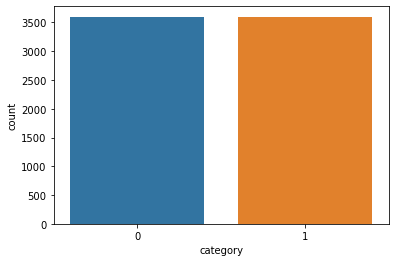

In [9]:
sns.countplot(df['category'])

In [10]:
stop = set(nltk.corpus.stopwords.words('portuguese'))
punctuation = list(string.punctuation)
stop.update(punctuation)
#stop.update(['ma','mai'])

In [11]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    #text = strip_html(text)
    #text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

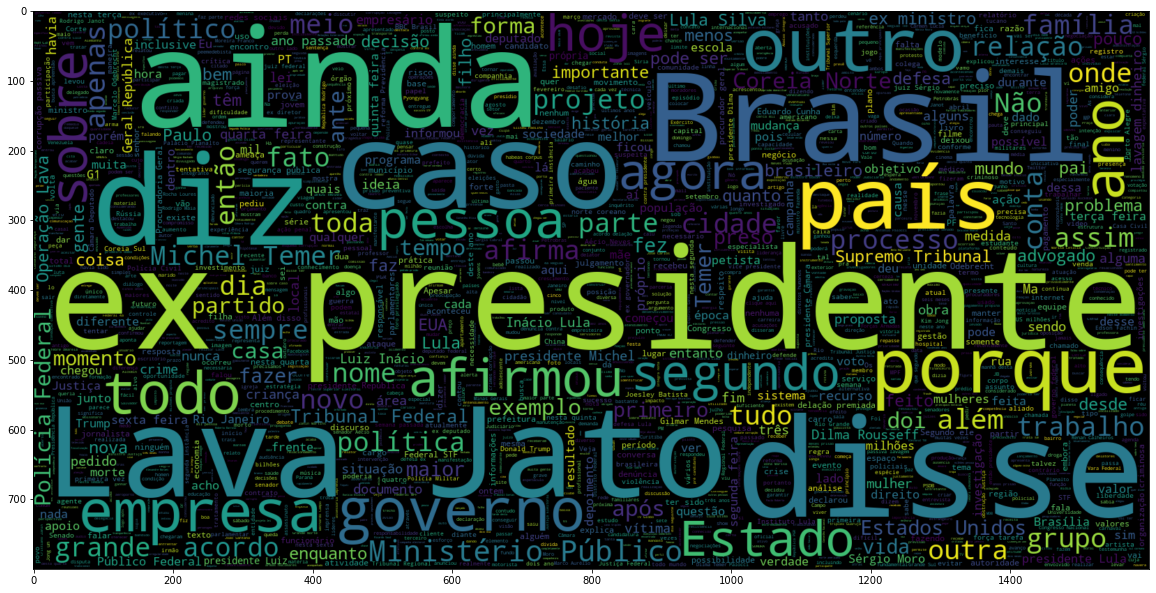

In [12]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

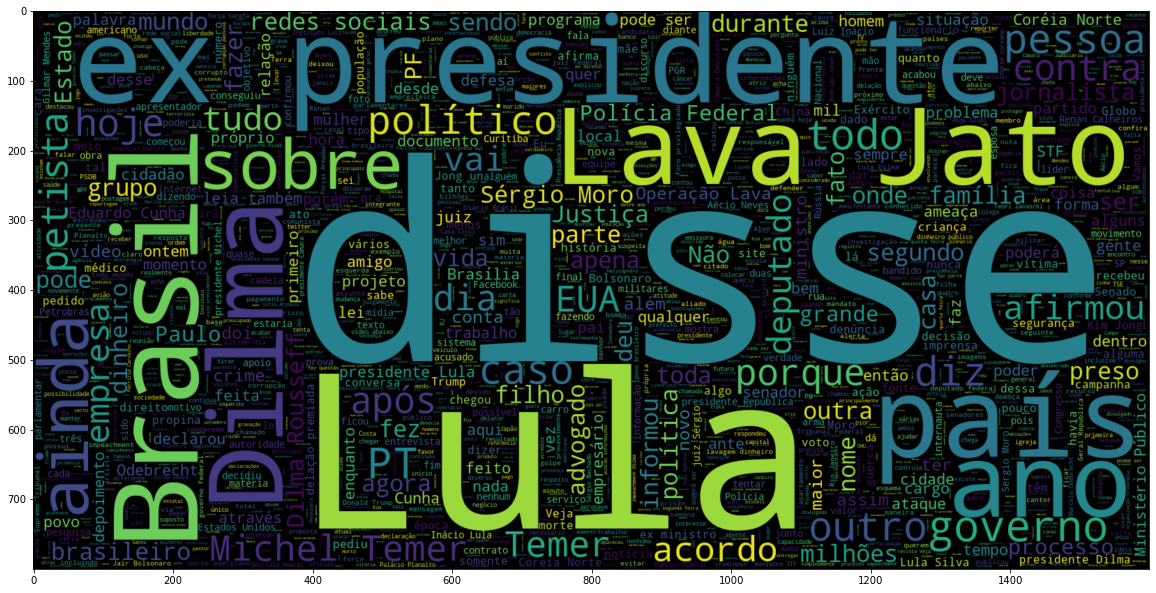

In [13]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

### Treinando Modelo

In [14]:
stopWords=nltk.corpus.stopwords.words('portuguese')

In [15]:
#stopWords

In [16]:
x_train,x_test,y_train,y_test = train_test_split(df['text'], df['category'], test_size=0.3, random_state=2020)

pipe = Pipeline([('vect', CountVectorizer(stop_words=stopWords)),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 96.53%


In [17]:
print(confusion_matrix(y_test, prediction))

[[1057   36]
 [  39 1028]]


In [18]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1093
           1       0.97      0.96      0.96      1067

    accuracy                           0.97      2160
   macro avg       0.97      0.97      0.97      2160
weighted avg       0.97      0.97      0.97      2160



In [19]:
print(x_test[1])

Bolsonaro liberal completo, diz presidente PSL Partido pouca expressão nacional, PSL vive momentos destaque inédito trajetória duas décadas. dia 5, sigla anunciou "receberia Jair Bolsonaro pré-candidatura Presidência República". palavra "filiação" consta termo divulgado imprensa, presidente PSL, deputado federal Luciano Bivar (PE), diz Folha que, "tão certo dois dois quatro", pré-candidato, hoje PSC, migrará partido março. acordo segundo colocado corrida presidencial momento, segundo pesquisas Datafolha, lançou luz sobre sigla nanica, provocou cisão: movimento Livres rompeu união quase dois anos PSL, objetivo refundar partido nova liderança. líderes grupo, Bolsonaro representa extremo oposto valores liberais, tanto termos econômicos quanto comportamentais, deveriam nortear nova fase partido. Bivar, entretanto, diz críticas preconceituosas. "Foi absurdo. maior parte partido favorável união. Ter preconceito contra pessoa fundamentalismo. lamento." Bolsonaro representa, diz Bivar, princíp

In [20]:
model.predict([x_test[1]])

array([1])

In [21]:
texto_falso='Dr. Ray peita Bolsonaro, chama-o de conservador fake em entrevista a Danilo Gentili e divide a direita.\n\nEste site vem avisando Jair Bolsonaro que ele deveria abandonar a pauta estatista de vez e fazer um discurso mais convincente para aquela boa parte dos liberais e conservadores do Brasil que querem se ver livres das amarras estatais.\n\nTudo bem que as pesquisas ainda dizem que a maior parte do povo é contra as privatizações, mas o índice (pouco mais de 50% do povo) é fácil de ser revertido. Ademais, Bolsonaro deveria falar para direitistas em vez de focar tanto em petistas arrependidos.\n\nRecentemente ele disse que pensaria 200 vezes antes de privatizar a Petrobrás para que ela não caia nas mãos de chineses (ou algo do tipo). Deveria ter dito: Eu garanto a privatização da Petrobrás, e também garanto que chineses não irão comprá-la. Isso não deixaria brechas. Do jeito que ele falou, parece que o suposto medo de venda aos chineses é pretexto para evitar a privatização.\n\nSeja lá como for, a direita vai ter que adotar alternativas que foquem em um estado reduzido, diminuição de impostos e venda de estatais. Além de João Amoedo, Dr. Rey está fazendo vicejar este tipo de discurso e  ainda que sua candidatura esteja em fase inicial  é complicado para Bolsonaro que apareçam pessoas de direita propondo uma visão economicamente direitista para a economia.\n\nEnfim, veja aos 32:40 Dr. Rey espinafrando Bolsonaro: Quem dá brechas não pode reclamar que os outros aproveitem, não é mesmo?'

In [22]:
model.predict([texto_falso])

array([0])

Peguei um texto do site do G1 do dia 14/06/2020:https://g1.globo.com/sp/sao-paulo/noticia/2020/06/14/manifestantes-fazem-ato-em-defesa-da-democracia-em-sp.ghtml

E coloquei na variável a seguir:

In [23]:
texto_verdadeiro='Manifestantes fazem ato em defesa da democracia e contra Bolsonaro em SP\n\nManifestantes realizaram um protesto na tarde deste domingo (14) na Avenida Paulista, Centro de São Paulo, em defesa da democracia, contra o presidente Jair Bolsonaro (sem partido), e contra o racismo. A concentração do ato começou às 14h em frente ao vão livre do Museu de Arte de São Paulo (Masp).\n\nO grupo seguiu em caminhada pela avenida, no sentido Paraíso, até próximo à estação Brigadeiro do Metrô, onde foi feito um discurso. O ato permaneceu pacífico até o final do trajeto. Por volta das 16h, iniciou-se a dispersão.\n\nTrês homens que portavam símbolos nazistas foram detidos. Mas, segundo a Secretaria de Segurança Pública (SSP), eles não participavam das manifestações e estariam apenas passando pela avenida quando uma mulher os denunciou para a polícia.\n\nO protesto foi realizado por integrantes das torcidas de quatro times de futebol (Corinthians, Palmeiras, São Paulo e Santos), entidades estudantis, Somos Democracia, Frente Povo Sem Medo, MTST (Movimento dos Trabalhadores Sem Teto), CMP (Central de Movimentos Populares), coletivo de mulheres, entre outros movimentos sociais.\n\nUma faixa grande com os dizeres "Fora Bolsonaro" foi estendida na avenida. Outros cartazes também traziam frases contra o fascismo e racismo.'

Prevendo corretamente como verdadeira

In [24]:
model.predict([texto_verdadeiro])

array([1])

Outro exemplo de notícia falsa:

In [25]:
texto_falso='NA ITÁLIA A CURA DO CORONAVIRUS É FINALMENTE ENCONTRADA.Os médicos italianos, desobedeceram a lei mundial da saúde da OMS, para não fazer autópsias nos mortos do Coronavírus e descobriram que NÃO é um VÍRUS, mas uma BACTERIA que causa a morte. Isso causa a formação de coágulos sanguíneos e causa a morte do paciente.TalA Itália derrota o chamado Covid-19, que nada mais é do que "Coagulação intravascular disseminada" (trombose).The E a maneira de combatê-lo, ou seja, sua cura, é com os “antibióticos, anti-inflamatórios e anticoagulantes”. ASPIRINA, indicando que esta doença foi mal tratada.Esta notícia sensacional para o mundo foi produzida por médicos italianos, realizando autópsias em cadáveres produzidos pelo Covid-19.OmAlgo mais, de acordo com patologistas italianos. "Os ventiladores e a unidade de terapia intensiva nunca foram necessários."Portanto, na Itália começou a mudança de protocolos, ITÁLIA A pandemia global tão conhecida é revelada e ressuscitada pela OMS, essa cura que os chineses já sabiam e não relataram PARA FAZER NEGÓCIOS.Fonte: Ministério da Saúde da Itália.COMPARTILHE QUE O MUNDO SABE QUE Fomos enganados e assassinados por nossas pessoas mais velhas !!!@ italiarevelacurardel­­­­­covid19ALERTA DOS OLHOSPasse isso para toda a sua família, vizinhança, conhecidos, amigos, colegas, colegas de trabalho ... etc. etc ... e seu ambiente em geral ...:Se eles contrairem o Covid-19 ... que não é um vírus como eles nos fizeram acreditar, mas uma bactéria ... amplificada com radiação eletromagnética 5G que também produz inflamação e hipóxia.Eles farão o seguinte:Eles vão tomar aspirina 100mg e Apronax ou Paracetamol ...Por quê? ... porque foi demonstrado que o que o Covid-19 faz é coagular o sangue, fazendo com que a pessoa desenvolva uma trombose e o sangue não flua e não oxigene o coração e os pulmões e a pessoa morra rapidamente devido a não ser capaz de respirar.Na Itália, eles estragaram o protocolo da OMS e fizeram uma autópsia em um cadáver que morreu de Covid-19 ... eles cortaram o corpo e abriram os braços e pernas e as outras seções do corpo e perceberam que as veias estavam dilatadas e coaguladas sangue e todas as veias e artérias cheias de trombos, impedindo que o sangue flua normalmente e levando oxigênio a todos os órgãos, principalmente ao cérebro, coração e pulmões e o paciente acabe morrendo,Já conhecendo esse diagnóstico, o Ministério da Saúde italiano mudou imediatamente os protocolos de tratamento Covid-19 ... e começou a administrar a seus pacientes positivos Aspirina 100mg e Apraxax ..., resultado: os pacientes começaram a se recuperar e apresentar melhorias e o Ministério of Health liberou e enviou para casa mais de 14.000 pacientes em um único dia.URGENTE: transmitir essas informações e torná-las virais, aqui em nosso país eles mentiram para nós, com essa pandemia, a única coisa que nosso presidente diz todos os dias são dados e estatísticas, mas não fornecer essas informações para salvar os cidadãos, será que também será ameaçado pelas elites? ... não sabemos, de repente todos os governos do mundo, mas a Itália quebrou a norma ... porque eles já estavam sobrecarregados e em sério caos de mortes diárias ..., agora a OMS. ... seria processado em todo o mundo por encobrir tantas mortes e o colapso das economias de muitos países do mundo ... agora entende-se por que a ordem para INCINERAR ou enterrar imediatamente os corpos sem autópsia ... e os rotulou como altamente poluente.Está em nossas mãos levar a verdade e esperar salvar muitas vidas ... ESPALHE EM TODAS AS REDES URGENTES !!!!! é por isso que o gel antibacteriano funciona e o dióxido de cloro ... Toda a PANDÊMICA é porque eles querem vacinar e chutar para assassinar as massas para controlá-las e reduzir a população mundial'

In [26]:
model.predict([texto_falso])

array([0])